In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import torch
import matplotlib.pyplot as plt

from dataloaders import Dataloader, MnistSpikesDataloader
from spiking import iterate_spikes
from spiking.layers import IntegrateAndFireOptimizedLayer
from spiking.learning import STDP
from spiking.competition import WinnerTakesAll
from spiking.evaluation import SpikingClassifierEvaluator
from spiking.threshold import NormalInitialization, CompetitiveFalezAdaptation
from spiking.training import Monitor

from visualization import SpikesVisualization

In [3]:
dataloader = MnistSpikesDataloader("./data/mnist-subset", 'train')
test_dataloader = MnistSpikesDataloader("./data/mnist-subset", 'test')
max_x, max_y = dataloader.inputs[0].shape
max_z = 2
max_input_spikes = max_x * max_y * max_z
print(f"{max_input_spikes = }")

max_input_spikes = 1568


In [4]:
def train(model: IntegrateAndFireOptimizedLayer, monitor: Monitor, num_epochs: int, *, visualize: bool = False):
    epochs = tqdm.tqdm(range(0, num_epochs))

    for epoch_idx in epochs:
        for batch_idx, (spikes, label, times) in enumerate(dataloader.iterate(batch_size=1), start=1):
            should_visualize = visualize and epoch_idx % 4 == 0 and batch_idx <= 3

            membrane_potentials = []
            membrane_potentials_times = []

            for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_z, max_x, max_y)):
                output_spike = model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
                if should_visualize:
                    if torch.any(output_spike == 1.0):
                        membrane_potentials.append([
                            model.thresholds[idx] if output_spike[idx] else model.membrane_potentials[idx]
                            for idx in range(model.num_outputs)
                        ])
                        membrane_potentials_times.append(current_time)
                    membrane_potentials.append(model.membrane_potentials.clone())
                    membrane_potentials_times.append(current_time)
                elif torch.any(output_spike == 1.0):
                    break
            pre_spike_times = times.flatten()

            loss = model.backward(pre_spike_times)
            threshold_mean = monitor.log(loss=loss)

            if should_visualize:
                post_spike_times = model.spike_times

                SpikesVisualization.plot_pre_post_spikes(
                    pre_spike_times.numpy(),
                    post_spike_times.numpy(),
                    title=f"Pre-synaptic vs Post-synaptic. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}",
                    unique_colors=True
                )
                SpikesVisualization.plot_multiple_membrane_potentials(
                    membrane_potentials,
                    membrane_potentials_times,
                    title=f"Membrane Potential Over Time. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}"
                )
            model.reset()
            epochs.set_postfix(loss=loss, threshold_mean=threshold_mean)

        model.threshold_adaptation.learning_rate_step()
        model.learning_mechanism.learning_rate_step()


def dataloader_to_spike_times(model: IntegrateAndFireOptimizedLayer, arg_dataloader: Dataloader):
    X, y = [], []
    for batch_idx, (spikes, label, _) in enumerate(arg_dataloader.iterate(batch_size=1), start=1):
        for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_x, max_y, max_z)):
            model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
        X.append(model.spike_times)
        y.append(label)
        model.reset()
    return torch.tensor(X), torch.tensor(y)

def eval_snn(model: IntegrateAndFireOptimizedLayer, *, visualize: bool = False):
    evaluator = SpikingClassifierEvaluator(model, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
    print(f"{evaluator.X_train.shape = }, {evaluator.y_train.shape = }")
    print(f"{evaluator.X_test.shape = }, {evaluator.y_test.shape = }")

    if visualize:
        evaluator.plot_reduced_dataset("train")
        evaluator.plot_reduced_dataset("val")
    accuracy, precision, recall, f1 = evaluator.train_classifier_and_compute_metrics(visualize=visualize)
    return accuracy, precision, recall, f1

def visualize_weights(model, neurons_indices=None):
    if neurons_indices is None:
        neurons_indices = range(model.num_outputs)

    for i in neurons_indices:
        img = model.weights[i].reshape((max_z, max_x, max_y))
        padding = torch.zeros((1, max_x, max_y), device=img.device)
        img = torch.cat([img, padding], dim=0)
        img = img.permute(1, 2, 0).detach().cpu().numpy()

        plt.title(f"Weights {i}")
        plt.axis("off")
        plt.imshow(img)
        plt.show()

## Fixed params

In [5]:
decay_lambda = 1.0
weights_lr0 = 0.1
adapt_lr0 = 5.0

tau = 0.1
beta = 1.0
stdp = STDP(
    tau_pre=tau, tau_post=tau, lr=weights_lr0, decay_factor=decay_lambda, max_pre_spike_time=1.0
)
wta = WinnerTakesAll()

min_threshold = 1.0
target_threshold = 0.7

threshold_initialization = NormalInitialization(min_threshold=min_threshold, std_dev=5.0)

## Test with some threshold mean and 30 epochs

In [6]:
threshold_mean = 75.0
num_epochs = 30
threshold_adaptation = CompetitiveFalezAdaptation(min_threshold=min_threshold, learning_rate=adapt_lr0, decay_factor=decay_lambda)
model_test = IntegrateAndFireOptimizedLayer(
    num_inputs=max_input_spikes,
    num_outputs=100,
    learning_mechanism=stdp,
    competition_mechanism=wta,
    threshold=threshold_mean,
    refractory_period=float('inf'),
    threshold_initialization=threshold_initialization,
    threshold_adaptation=threshold_adaptation,
)
monitor = Monitor(model_test)
train(model_test, monitor=monitor, num_epochs=num_epochs, visualize=False)

100%|██████████| 30/30 [06:16<00:00, 12.54s/it, loss=0.00525, threshold_mean=74.4] 


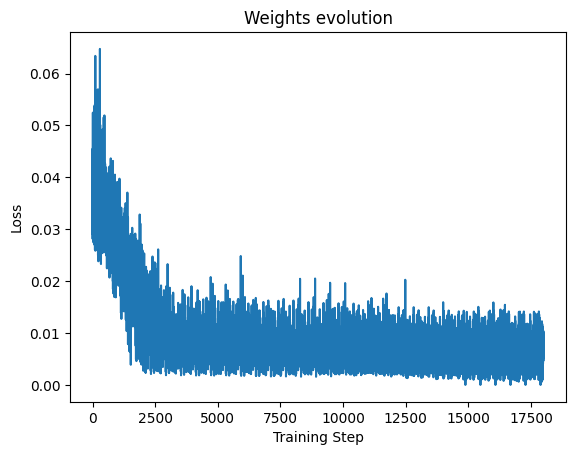

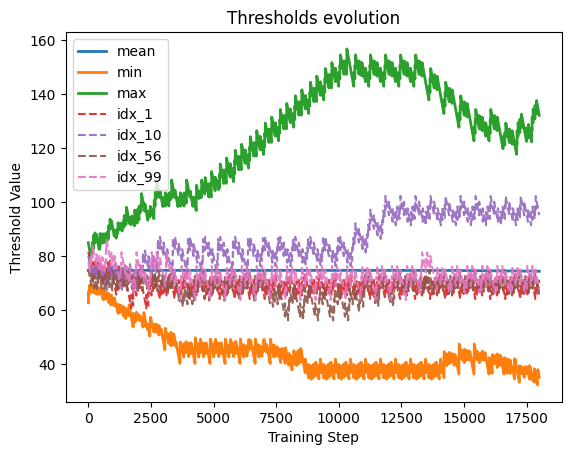

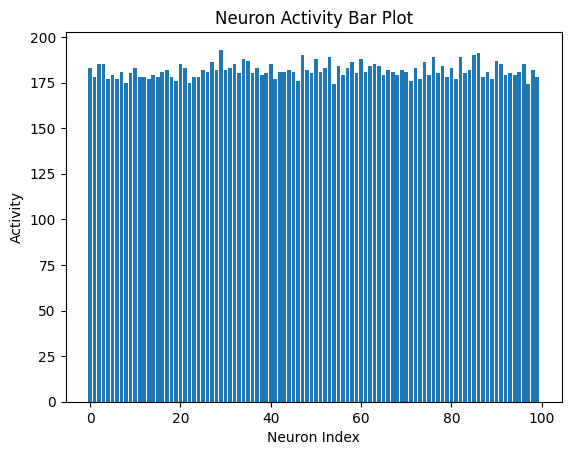

In [7]:
monitor.plot_weight_evolution(title="Weights evolution")
monitor.plot_thresholds_evolution(title="Thresholds evolution")
monitor.plot_neurons_activity()

evaluator.X_train.shape = (600, 100), evaluator.y_train.shape = (600,)
evaluator.X_test.shape = (100, 100), evaluator.y_test.shape = (100,)


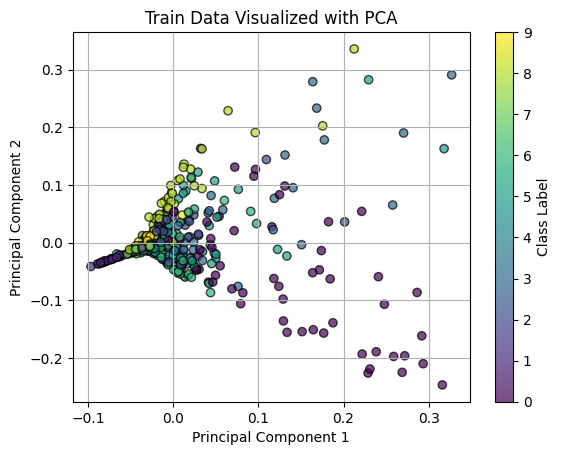

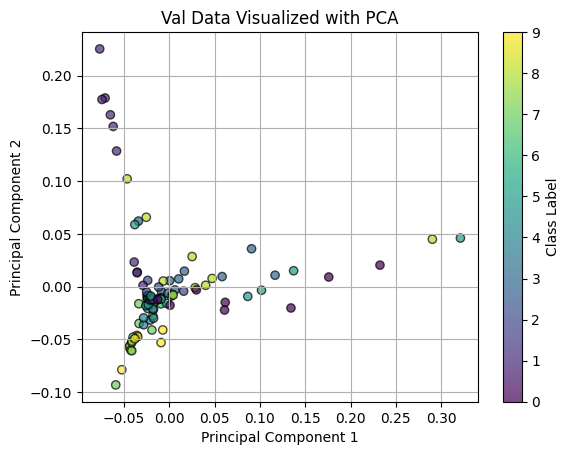

Train accuracy: 0.8883333333333333
Accuracy: 0.78
Precision: 0.82
Recall: 0.78
F1 Score: 0.78


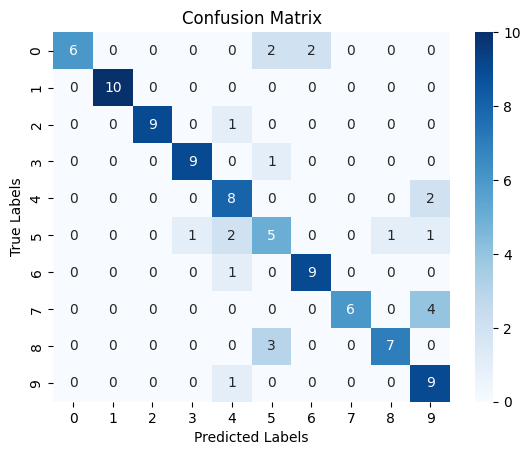

(0.78, 0.8225611888111889, 0.78, 0.7846439398384478)

In [8]:
eval_snn(model_test, visualize=True)

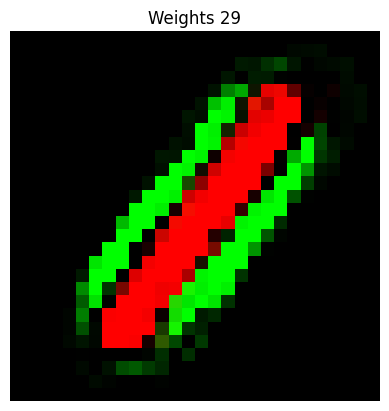

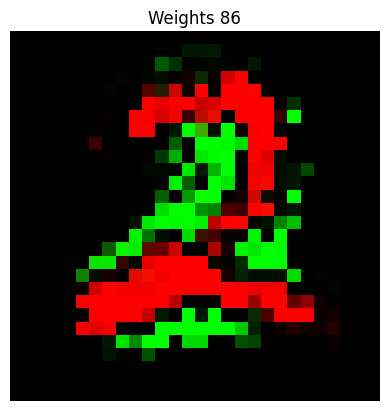

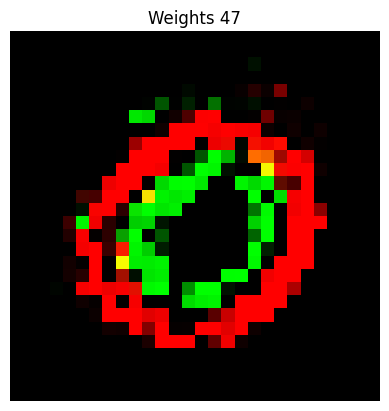

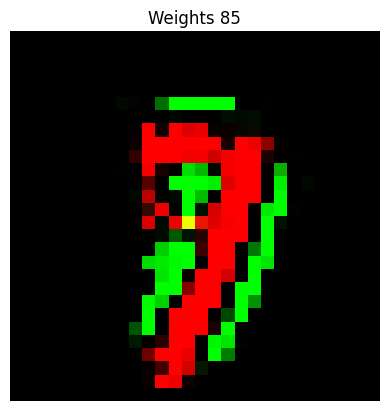

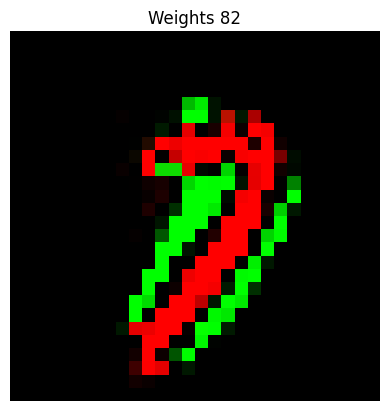

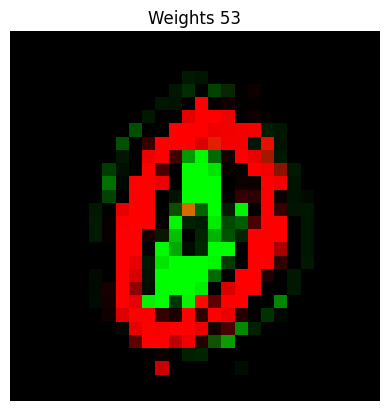

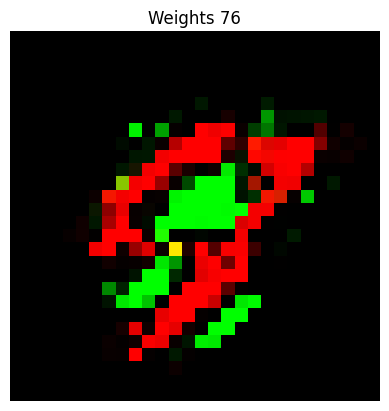

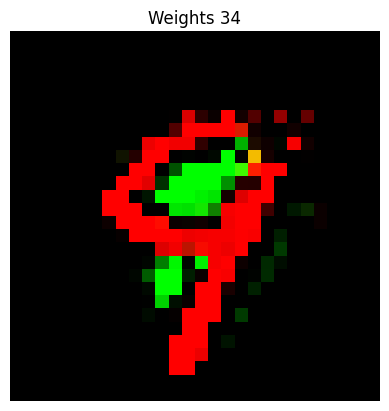

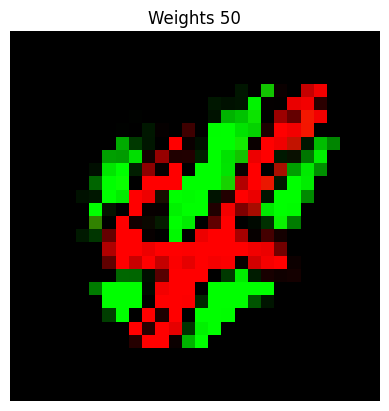

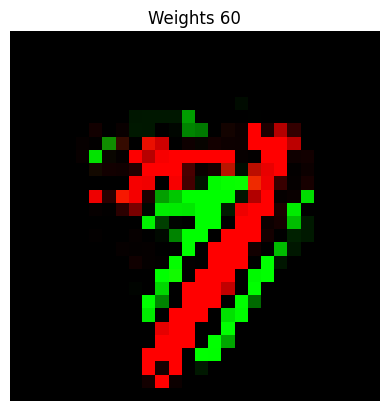

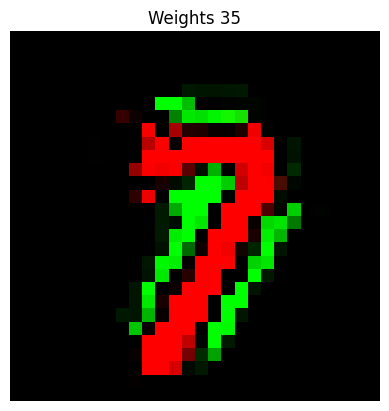

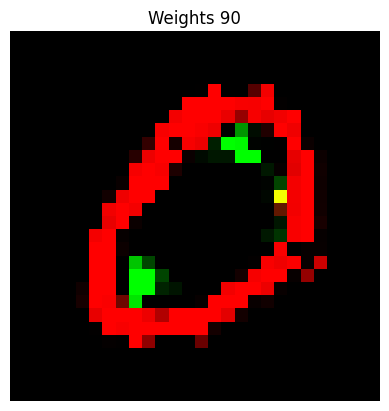

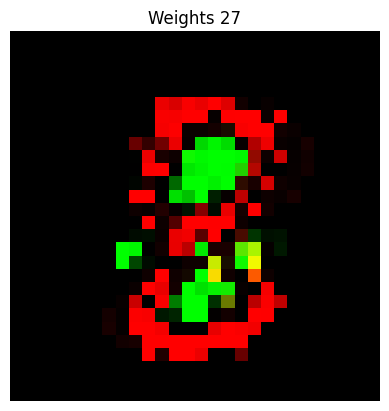

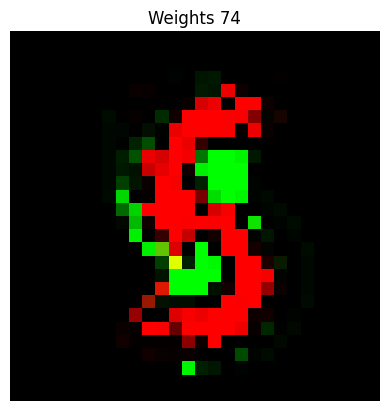

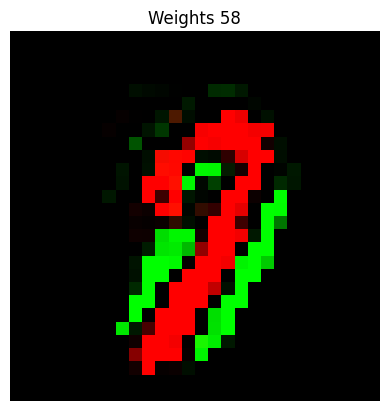

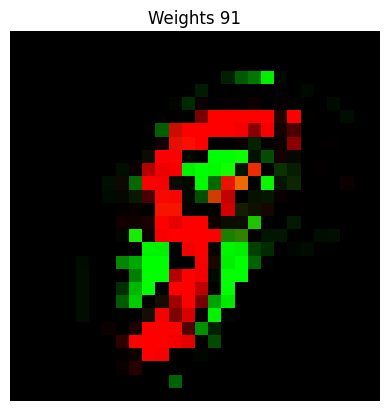

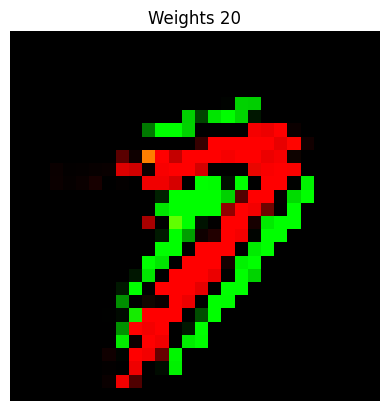

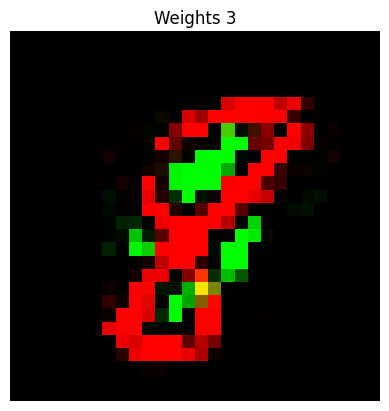

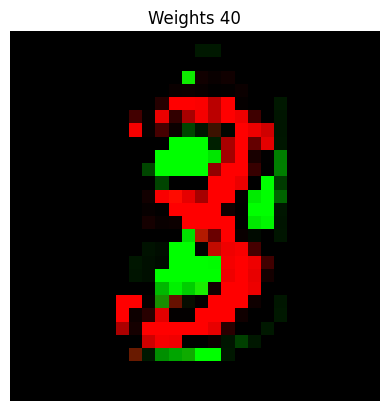

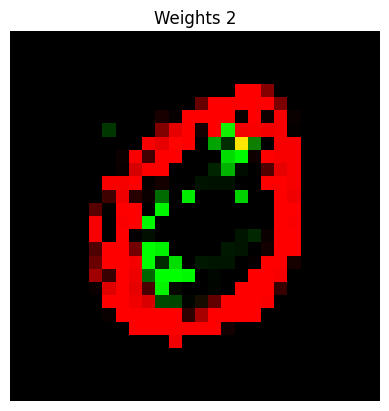

In [9]:
visualize_weights(model_test, monitor.most_active_neurons(20))